# KDE & ML Based NuMu Event Reconstruction

### Import Classes & Modules

    Ensure all required python classes are installed prior to progress.

In [1]:
import os
import sys
import time
import math
import warnings
import struct
import binascii
import pandas as pd
import numpy as np
import pickle
import h5py
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

--------------------------------------------------------------------------
[[10938,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: gpu201901

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
2023-02-17 13:38:51.597741: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from datetime import datetime
from sklearn import preprocessing
from tqdm import tqdm,tqdm_notebook
from IPython.display import display, clear_output
from matplotlib.image import imread # read images
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
from numpy.polynomial.polynomial import polyfit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Activation,concatenate
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.python.client import device_lib
from sklearn.preprocessing import MinMaxScaler # normalize and scale data
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,r2_score

### Data Handling

In [5]:
# create directory paths for train & test data sets
data_dir='/home/m962g264/research_repo/data-preprocess'
train_path=data_dir+'/ND_MC_Nominal_RHC_traindata/'
test_path=data_dir+'/ND_MC_Nominal_RHC_testdata/'
print('Training files path: \t{}'.format(train_path))
print('Validation files path: \t{}'.format(test_path))

Training files path: 	/home/m962g264/research_repo/data-preprocess/ND_MC_Nominal_RHC_traindata/
Validation files path: 	/home/m962g264/research_repo/data-preprocess/ND_MC_Nominal_RHC_testdata/


In [6]:
train_files = list(set(n for n in os.listdir(train_path) if n.endswith(".h5")))
test_files = list(set(n for n in os.listdir(test_path) if n.endswith(".h5")))
# train & test size
train_idx=0
test_idx=0
for h5_filename in os.listdir(train_path):
        #Adding these two lines to avoid errors because there are extra directories in the FHC set for some reason
    if os.path.isdir(h5_filename)==True:
        continue
    train_idx=train_idx+len((h5py.File(train_path+h5_filename,'r')))
for h5_filename in os.listdir(test_path):
    test_idx=test_idx+len((h5py.File(test_path+h5_filename,'r')))

# training events are broad scoped while validation events are quality cut ND contained. further train/test splitting is done later.
print('Number of training files:\t{}\nNumber of validation files:\t{}'.format(len(os.listdir(train_path)), len(os.listdir(test_path))))
print('Number of training events:\t{}\nNumber of validation events:\t{}'.format((train_idx), (test_idx)))

Number of training files:	2000
Number of validation files:	2000
Number of training events:	32000
Number of validation events:	32000


In [7]:
# test interaction is canoncial for training files
df=h5py.File(train_path+os.listdir(train_path)[0],'r')
print(list(df.keys()))

['E', 'Mode', 'PDG', 'TrueRecoVtxX', 'TrueRecoVtxY', 'TrueRecoVtxZ', 'cvnmap', 'cycle', 'event', 'firstplane', 'isCC', 'lastcellx', 'lastcelly', 'run', 'slice', 'subrun']


In [8]:
# read all the h5 files
idx=0
energy,pdg,cvnmap,test_cvnmap,truerecovtxx,truerecovtxy,truerecovtxz,test_mode,test_iscc,testtruerecovtxx,testtruerecovtxy,testtruerecovtxz=([] for i in range(12))
for h5_filename in os.listdir(train_path):
    print('Processing... {} of {}'.format(idx,len(os.listdir(train_path))), end="\r", flush=True)
    energy=np.append(energy, h5py.File(train_path+h5_filename,'r')['E'][:],axis=0)
    pdg=np.append(pdg,h5py.File(train_path+h5_filename,'r')['PDG'][:],axis=0)
    cvnmap.append(h5py.File(train_path+h5_filename,'r')['cvnmap'][:])
    truerecovtxx.append(h5py.File(train_path+h5_filename,'r')['TrueRecoVtxX'][:])
    test_cvnmap.append(h5py.File(test_path+h5_filename,'r')['cvnmap'][:])
    train_mode=np.append(test_mode,h5py.File(train_path+h5_filename,'r')['Mode'][:],axis=0)
    train_iscc=np.append(test_iscc,h5py.File(train_path+h5_filename,'r')['isCC'][:],axis=0)
    test_mode=np.append(test_mode,h5py.File(test_path+h5_filename,'r')['Mode'][:],axis=0)
    test_iscc=np.append(test_iscc,h5py.File(test_path+h5_filename,'r')['isCC'][:],axis=0)
    testtruerecovtxx.append(h5py.File(test_path+h5_filename,'r')['TrueRecoVtxX'][:])
    idx+=1

# convert to np array
truerecovtxx=np.array(truerecovtxx)
testtruerecovtxx=np.array(testtruerecovtxx)
print('Test & Validation files read successful') 

Test & Validation files read successful


In [9]:
# normalize cvnmap for CNN processing
# training data
idx=file=0
cvnmap_norm,test_cvnmap_norm=([] for i in range(2))
while idx < (len(os.listdir(train_path))):
        #seeing if we can fix the index problem
    if idx==2001:
        break
    cvnmap_norm.append(preprocessing.normalize(cvnmap[idx],axis=1))
    idx+=1
# testing data
while file < (len(os.listdir(test_path))):
    test_cvnmap_norm.append(preprocessing.normalize(test_cvnmap[file],axis=1))
    file+=1
# convert to np array
cvnmap_norm=np.array(cvnmap_norm)
test_cvnmap_norm=np.array(test_cvnmap_norm)

In [10]:
# extract true vertices for model training processing and model validation
truevtxx,recovtxx,testtruevtxx,testrecovtxx=([] for i in range(4))
idx=0
while idx < (len(os.listdir(train_path))):
        print('Processing...', end="\r", flush=True)
        event=0
            #seeing if we can fix the index problem
        if idx==2001:
            break
        while event < (truerecovtxx[idx].shape[0]):
            truevtxx=np.append(truevtxx,truerecovtxx[idx][event][0])
            recovtxx=np.append(recovtxx,truerecovtxx[idx][event][1])
            event+=1
        idx+=1
print('Training preprocessing complete\n', end="\r", flush=True)
idx=0
while idx < (len(os.listdir(test_path))):
        print('Processing...', end="\r", flush=True)
        event=0
        while event < (testtruerecovtxx[idx].shape[0]):
            testtruevtxx=np.append(testtruevtxx,testtruerecovtxx[idx][event][0])
            testrecovtxx=np.append(testrecovtxx,testtruerecovtxx[idx][event][1])
            event+=1
        idx+=1
print('Testing preprocessing complete\n', end="\r", flush=True)
# convert to np arrays
testtruevtxx=np.array(testtruevtxx)
testrecovtxx=np.array(testrecovtxx)

Training preprocessing complete
Testing preprocessing complete


In [11]:
# split normalized cvnmap into reshaped events with multi-views
a,b,c,d,cvnmap_norm_resh,cvnmap_norm_resh_xz,cvnmap_norm_resh_yz,test_cvnmap_norm_resh,test_cvnmap_norm_resh_xz,test_cvnmap_norm_resh_yz=([] for i in range(10))
file=event=0
## training CVN map view split ##
while file < (len(os.listdir(train_path))):
        #seeing if we can fix the index problem
    if idx==2001:
        break
    a=cvnmap_norm[file]
    print('Processing train cvnmap file {} of {}'.format(file+1, (len(os.listdir(train_path)))), end="\r", flush=True)
    event=0
    while event < (a.shape[0]):
        b=a[event].reshape(2,100,80)
        cvnmap_norm_resh.append(b)
        cvnmap_norm_resh_xz.append(b[0])
        cvnmap_norm_resh_yz.append(b[1])
        event+=1
    file+=1
file=event=0
while file < (len(os.listdir(test_path))):
    c=test_cvnmap_norm[file]
    print('Processing tests cvnmap file {} of {}'.format(file+1, (len(os.listdir(test_path)))), end="\r", flush=True)
    event=0
    while event < (c.shape[0]):
        d=c[event].reshape(2,100,80)
        test_cvnmap_norm_resh.append(d)
        test_cvnmap_norm_resh_xz.append(d[0])
        test_cvnmap_norm_resh_yz.append(d[1])
        event+=1
    file+=1
print('\ncvnmap processing complete')

Processing tests cvnmap file 2000 of 2000
cvnmap processing complete


In [13]:
#Defines the finalstate array! Need to make a numpy array from the extracted final state pdg information
pdgpath='/home/m962g264/research_repo/data-preprocess/ND_MC_Nominal_Files_RHC_mominkhan/'
idx=0
for h5_filename in os.listdir(pdgpath):
    print('Processing... {} of {}'.format(idx,len(os.listdir(train_path))), end="\r", flush=True)
   
    g=h5py.File(pdgpath+h5_filename,'r')
    finalstate=g['rec.mc.nu.prim']['pdg'][:]
  
    #if 111 in finalstate:
        #print(finalstate)
        #print(len(finalstate))
    #else:
        #continue
    idx+=1
    
# convert to np array
print('Test & Validation files read successful') 

Test & Validation files read successful


##### Split Datasets by Interaction Types

In [14]:
test_cvnmap_qe_xz,test_cvnmap_qe_yz,test_cvnmap_res_xz,test_cvnmap_res_yz,test_cvnmap_dis_xz,test_cvnmap_dis_yz=([] for i in range(6))
qe_true_vtxx,res_true_vtxx,dis_true_vtxx,qe_reco_vtxx,res_reco_vtxx,dis_reco_vtxx=([] for i in range(6))
x=idx=0
print('Processing {} test files. Splitting events by interaction mode.'.format((len(test_mode))))
#############MODE####################################################
while idx < (len(test_mode)):
    time.sleep(0.001) # hesitates for 0.001 seconds to prevent server comm errors
    print('MODE RUN: Processing train file {}'.format(idx), end="\r", flush=True)
    if test_mode[idx] == 0.0: # quasi-elastic
        test_cvnmap_qe_xz.append(test_cvnmap_norm_resh_xz[idx])
        test_cvnmap_qe_yz.append(test_cvnmap_norm_resh_yz[idx])
        qe_true_vtxx.append(testtruevtxx[idx])
        qe_reco_vtxx.append(testrecovtxx[idx])
    elif test_mode[idx] == 1.0: # resonance state
        test_cvnmap_res_xz.append(test_cvnmap_norm_resh_xz[idx])
        test_cvnmap_res_yz.append(test_cvnmap_norm_resh_yz[idx])
        res_true_vtxx.append(testtruevtxx[idx])
        res_reco_vtxx.append(testrecovtxx[idx])
    elif test_mode[idx] == 2.0: # deep inelastic
        test_cvnmap_dis_xz.append(test_cvnmap_norm_resh_xz[idx])
        test_cvnmap_dis_yz.append(test_cvnmap_norm_resh_yz[idx])
        dis_true_vtxx.append(testtruevtxx[idx])
        dis_reco_vtxx.append(testrecovtxx[idx])
    idx+=1
print('\nJob complete.')

Processing 72710 test files. Splitting events by interaction mode.
MODE RUN: Processing train file 72709
Job complete.


In [15]:
#############CC/NC###################################################
test_cvnmap_cc_xz,test_cvnmap_cc_yz,test_cvnmap_nc_xz,test_cvnmap_nc_yz=([] for i in range(4))
cc_true_vtxx,nc_true_vtxx,cc_reco_vtxx,nc_reco_vtxx=([] for i in range(4))
x=idx=0
print('Processing {} test files. Splitting events by interactions current charge.'.format((len(test_mode))))
while idx < (len(test_mode)):
    time.sleep(0.001) # hesitates for 0.001 seconds to prevent server comm errors
    print('CC/NC RUN: Processing train file {}'.format(idx), end="\r", flush=True)
    if test_iscc[idx] == 1.0: # cc
        test_cvnmap_cc_xz.append(test_cvnmap_norm_resh_xz[idx])
        test_cvnmap_cc_yz.append(test_cvnmap_norm_resh_yz[idx])
        cc_true_vtxx.append(testtruevtxx[idx])
        cc_reco_vtxx.append(testrecovtxx[idx])
    elif test_iscc[idx] == 0.0: # nc
        test_cvnmap_nc_xz.append(test_cvnmap_norm_resh_xz[idx])
        test_cvnmap_nc_yz.append(test_cvnmap_norm_resh_yz[idx])
        nc_true_vtxx.append(testtruevtxx[idx])
        nc_reco_vtxx.append(testrecovtxx[idx])
    idx+=1
print('\nJob complete.')

Processing 72710 test files. Splitting events by interactions current charge.
CC/NC RUN: Processing train file 72709
Job complete.


In [16]:
# extract reco data sets from training
qe_reco_vtxx,res_reco_vtxx,dis_reco_vtxx=([] for i in range(3))
qe_reco_true_vtxx,res_reco_true_vtxx,dis_reco_true_vtxx=([] for i in range(3))
x=idx=0
print('Processing {} train files. Splitting events by interaction mode.'.format((len(train_mode))))
#############MODE####################################################
while idx < (len(train_mode)):
    time.sleep(0.001) # hesitates for 0.001 seconds to prevent server comm errors
    print('MODE RUN: Processing train file {}'.format(idx), end="\r", flush=True)
    if train_mode[idx] == 0.0: # quasi-elastic
        qe_reco_vtxx.append(recovtxx[idx])
        qe_reco_true_vtxx.append(truevtxx[idx])
    elif train_mode[idx] == 1.0: # resonance state
        res_reco_vtxx.append(recovtxx[idx])
        res_reco_true_vtxx.append(truevtxx[idx])
    elif train_mode[idx] == 2.0: # deep inelastic
        dis_reco_vtxx.append(recovtxx[idx])
        dis_reco_true_vtxx.append(truevtxx[idx])
    idx+=1
print('\nJob complete.')

Processing 72721 train files. Splitting events by interaction mode.
MODE RUN: Processing train file 72720
Job complete.


In [17]:
#############CC/NC###################################################
cc_reco_vtxx,nc_reco_vtxx,cc_reco_true_vtxx,nc_reco_true_vtxx=([] for i in range(4))
x=idx=0
print('Processing {} test files. Splitting events by interactions current charge.'.format((len(train_mode))))
while idx < (len(train_mode)):
    time.sleep(0.001) # hesitates for 0.001 seconds to prevent server comm errors
    print('CC/NC RUN: Processing train file {}'.format(idx), end="\r", flush=True)
    if train_iscc[idx] == 1.0: # cc
        cc_reco_vtxx.append(recovtxx[idx])
        cc_reco_true_vtxx.append(truevtxx[idx])
    elif train_iscc[idx] == 0.0: # nc
        nc_reco_vtxx.append(recovtxx[idx])
        nc_reco_true_vtxx.append(truevtxx[idx])
    idx+=1
print('\nJob complete.')

Processing 72721 test files. Splitting events by interactions current charge.
CC/NC RUN: Processing train file 72720
Job complete.


###### Statistics of Interactions

In [18]:
print('Ratio: QES = {}, RES = {}, DIS = {}'.format((sum(test_mode==0.0)/len(test_mode)),(sum(test_mode==1.0)/len(test_mode)),(sum(test_mode==2.0)/len(test_mode))))
print('Ratio: CC = {}, NC = {}'.format((sum(test_iscc==1.0)/len(test_iscc)),((len(test_iscc)-sum(test_iscc==1.0))/len(test_iscc))))

Ratio: QES = 0.17861367074680237, RES = 0.44809517260349335, DIS = 0.28531151148397743
Ratio: CC = 0.5218814468436254, NC = 0.47811855315637464


    The np array conversions below must be done independently to bypass kernel crash.

In [19]:
# plot aesthetics
cmap_reversed = plt.cm.get_cmap('gist_heat_r')
plt.rcParams["font.family"] = "Times New Roman"
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist]
#[f.name for f in matplotlib.font_manager.fontManager.afmlist]

['cmex10',
 'STIXSizeFourSym',
 'DejaVu Sans Mono',
 'cmb10',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'cmsy10',
 'STIXGeneral',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXNonUnicode',
 'DejaVu Sans Display',
 'DejaVu Sans',
 'STIXSizeTwoSym',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXSizeThreeSym',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'cmtt10',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeOneSym',
 'cmr10',
 'STIXSizeFiveSym',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'DejaVu Serif Display',
 'cmss10',
 'DejaVu Serif',
 'DejaVu Sans',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'cmmi10',
 'WenQuanYi Micro Hei',
 'Liberation Mono',
 'STIX MathJax Normal',
 'MathJax_Size3',
 'STIX MathJax Main',
 'STIX MathJax Variants',
 'Lohit Bengali',
 'MathJax_Size2',
 'Waree',
 'Liberation Sans',
 'Open Sans',
 'Waree',
 'DejaVu Sans',
 'MathJax_Vector',
 'PakType Naskh Basic',
 'STIX MathJax Marks',
 'STIX MathJax DoubleStruck',
 'STIX

In [20]:
def plot_event_with_vtx(event1,event2,idx=0):
    pixelmap1=event1[idx]
    pixelmap2=event2[idx]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    # added [:-20] to end of pixelmap[X] to preview square images for CNN
    sns.heatmap(pixelmap1[:-20],cmap=cmap_reversed,cbar=False,square=True,xticklabels=10,yticklabels=10,ax=axes[0])
    sns.heatmap(pixelmap2[:-20],cmap=cmap_reversed,cbar=False,square=True,xticklabels=10,yticklabels=10,ax=axes[1])
#    plt.imshow(pixelmap[1][:-20], cmap=cmap_reversed, interpolation='nearest')
#    axes[0].scatter(x=vtxx,y=vtxz,c='yellow',marker='x',s=50)
#    axes[1].scatter(x=vtxy,y=vtxz,c='yellow',marker='x',s=50)
#    plt.suptitle("XZ & YZ Plot", fontsize=30)
#    print('UX Specified Fields\nEvent Number:\t{}'.format(idx))
#    print('CVN Vertex Position (x,y,z) = ({},{},{})'.format(f'{vtxx:.3}',f'{vtxy:.3}',f'{vtxz:.3}'))
    axes[0].set_xlabel("Cell",fontdict=font)
    axes[0].set_ylabel("Plane", fontdict=font)
    axes[0].set_title('XZ-View',fontdict=font)
    axes[0].set_xlim(10,70)
    axes[0].set_ylim(40,0)
    axes[1].set_xlabel("Cell",fontdict=font)
    axes[1].set_ylabel("Plane",fontdict=font)
    axes[1].set_title('YZ-View',fontdict=font)
    axes[1].set_xlim(10,70)
    axes[1].set_ylim(40,0)
    sns.despine(bottom = False, top=False, right=False, left = False)
    plt.savefig('cvnpixelmapqe.pdf')
    plt.tight_layout()
    plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


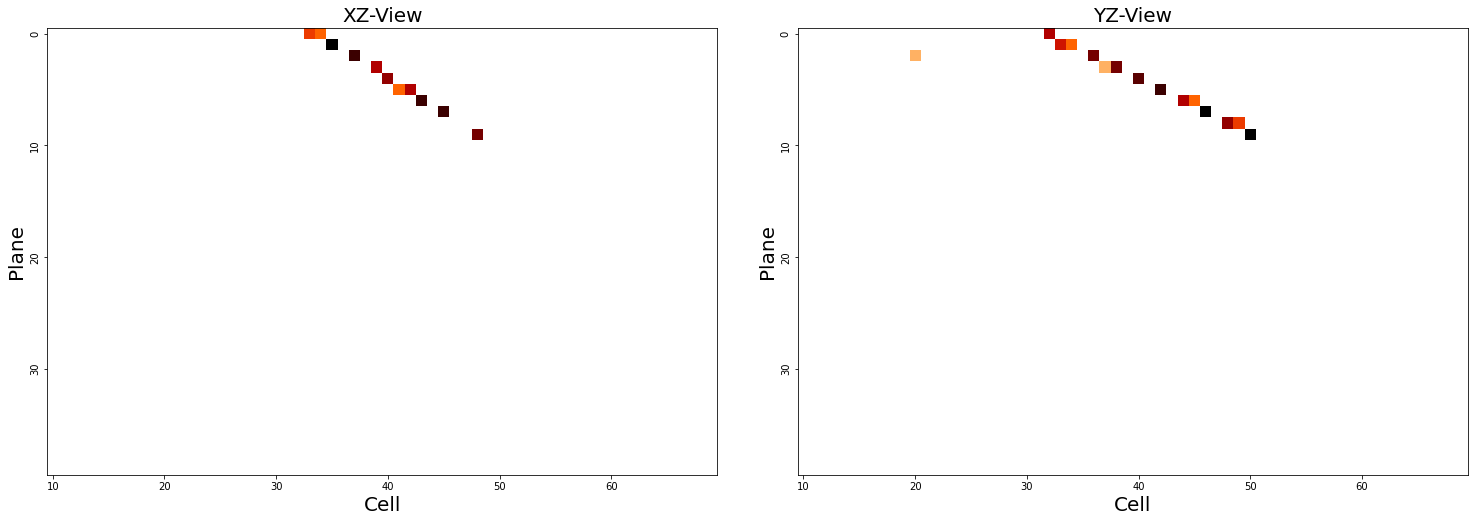

In [21]:
plot_event_with_vtx(test_cvnmap_qe_xz,test_cvnmap_qe_yz,idx=5889)

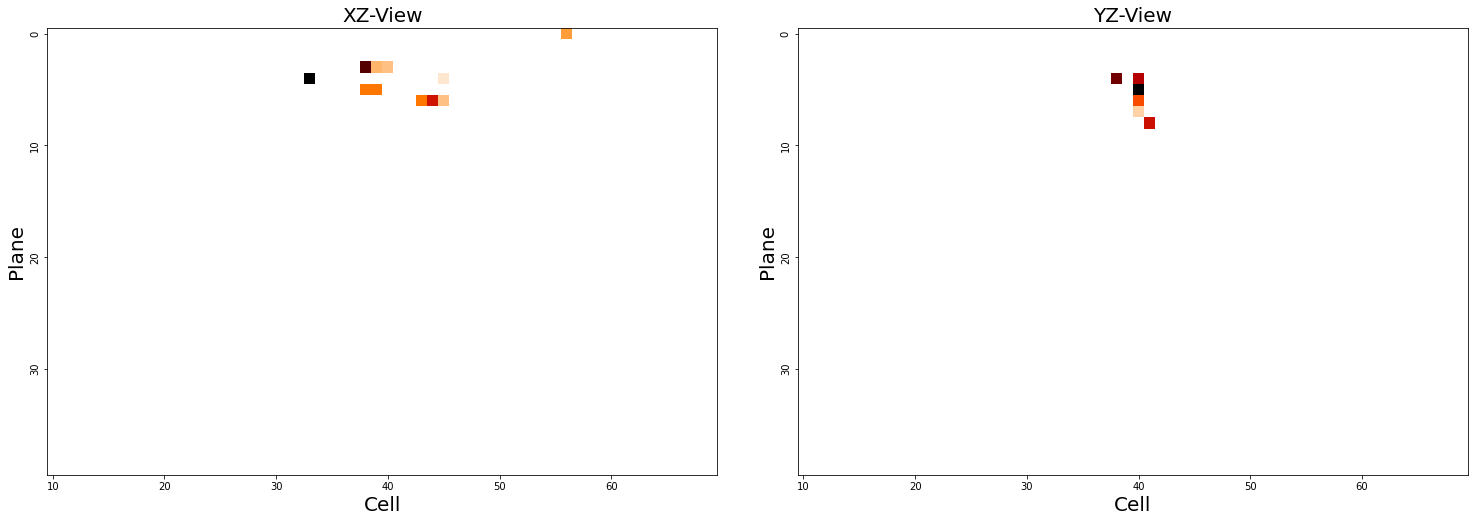

In [22]:
plot_event_with_vtx(test_cvnmap_dis_xz,test_cvnmap_dis_yz,idx=1395)

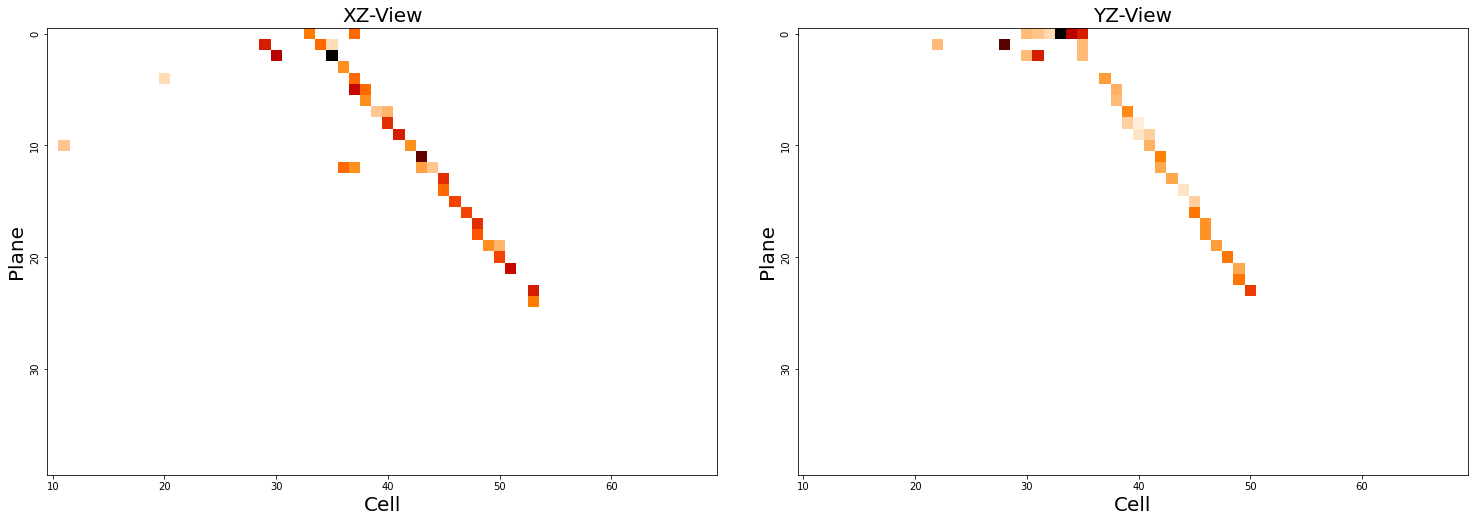

In [23]:
plot_event_with_vtx(test_cvnmap_res_xz,test_cvnmap_res_yz,idx=1395)

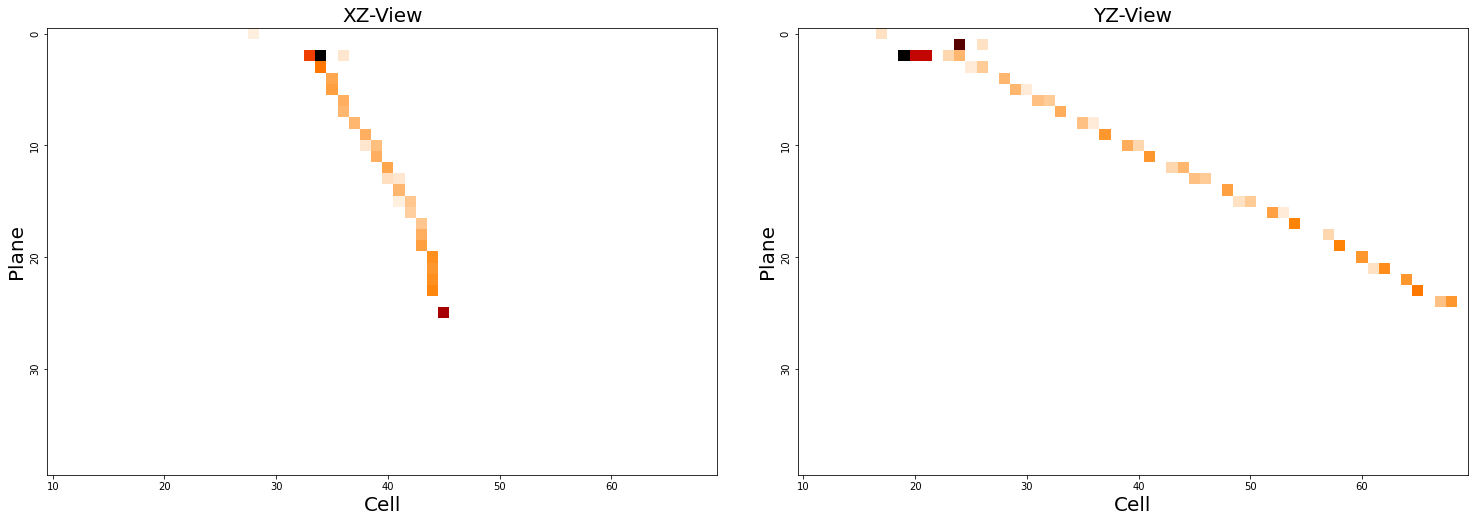

<Figure size 432x288 with 0 Axes>

In [24]:
# verify events plot normally with callable function
#plot_event_with_vtx(cvnmap_norm_resh,idx=2)
plot_event_with_vtx(cvnmap_norm_resh_xz,cvnmap_norm_resh_yz,idx=2)
plt.tight_layout()

In [25]:
# mutli dimensional xz & yz views for each event. this is used for plotting events only
cvnmap_norm_resh=np.array(cvnmap_norm_resh) 

In [26]:
cvnmap_norm_resh_xz=np.array(cvnmap_norm_resh_xz) # xz views only

In [27]:
cvnmap_norm_resh_yz=np.array(cvnmap_norm_resh_yz) # yz views only

In [28]:
test_cvnmap_qe_xz=np.array(test_cvnmap_qe_xz)
test_cvnmap_qe_yz=np.array(test_cvnmap_qe_yz)

In [29]:
test_cvnmap_res_xz=np.array(test_cvnmap_res_xz)
test_cvnmap_res_yz=np.array(test_cvnmap_res_yz)

In [30]:
test_cvnmap_dis_xz=np.array(test_cvnmap_dis_xz)
test_cvnmap_dis_yz=np.array(test_cvnmap_dis_yz)

In [31]:
test_cvnmap_cc_xz=np.array(test_cvnmap_cc_xz)
test_cvnmap_cc_yz=np.array(test_cvnmap_cc_yz)

In [32]:
test_cvnmap_nc_xz=np.array(test_cvnmap_nc_xz)
test_cvnmap_nc_yz=np.array(test_cvnmap_nc_yz)

In [33]:
test_cvnmap_norm_resh_xz=np.array(test_cvnmap_norm_resh_xz) # xz views only

In [34]:
test_cvnmap_norm_resh_yz=np.array(test_cvnmap_norm_resh_yz) # yz views only

In [35]:
def plot_event_with_vtx(event,idx=0):
    pixelmap=event[idx]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    # added [:-20] to end of pixelmap[X] to preview square images for CNN
    sns.heatmap(pixelmap[0][:-20],cmap='coolwarm',cbar=False,square=True,xticklabels=10,yticklabels=10,ax=axes[0])
    sns.heatmap(pixelmap[1][:-20],cmap='coolwarm',cbar=False,square=True,xticklabels=10,yticklabels=10,ax=axes[1])
#    axes[0].scatter(x=vtxx,y=vtxz,c='yellow',marker='x',s=50)       # comment/uncomment to plot/unplot vertex point
#    axes[1].scatter(x=vtxy,y=vtxz,c='yellow',marker='x',s=50)       # comment/uncomment to plot/unplot vertex point
    plt.suptitle("XZ & YZ Plot", fontsize=30)
    print('UX Specified Fields\nEvent Number:\t{}'.format(idx))
#    print('CVN Vertex Position (x,y,z) = ({},{},{})'.format(f'{vtxx:.3}',f'{vtxy:.3}',f'{vtxz:.3}'))
    axes[0].set_xlabel("Cell", fontsize=25)
    axes[0].set_ylabel("Plane", fontsize=25)
    axes[1].set_xlabel("Cell", fontsize=25)
    axes[1].set_ylabel("Plane", fontsize=25)
#    plt.savefig('event.pdf')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


UX Specified Fields
Event Number:	5


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


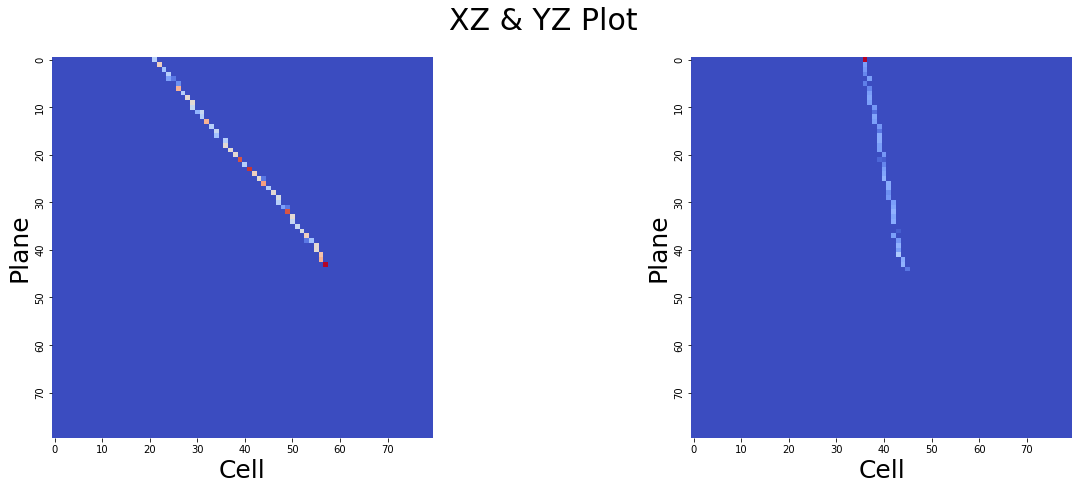

In [36]:
# verify events plot normally with callable function
plot_event_with_vtx(cvnmap_norm_resh,idx=5)

### GPU Test

In [ ]:
# see if GPU is recognized
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
print(sess)
print(device_lib.list_local_devices())

    +-----------------------------------------------------------------------------+
    | NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
    |-------------------------------+----------------------+----------------------+
    | GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
    | Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
    |===============================+======================+======================|
    |   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
    | N/A   33C    P0    34W / 250W |  15431MiB / 16160MiB |      0%      Default |
    +-------------------------------+----------------------+----------------------+
    |   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
    | N/A   34C    P0    34W / 250W |      0MiB / 16160MiB |      5%      Default |
    +-------------------------------+----------------------+----------------------+
                                                                                   
    +-----------------------------------------------------------------------------+
    | Processes:                                                       GPU Memory |
    |  GPU       PID   Type   Process name                             Usage      |
    |=============================================================================|
    |    0    152871      C   python3                                    15419MiB |
    +-----------------------------------------------------------------------------+

#### Prepare the Training & Test Sets

In [ ]:
# XZ view. Trains on the x-coordinate
X1_train, X1_test, y1_train, y1_test = train_test_split(cvnmap_norm_resh_xz, truevtxx, test_size=0.25, random_state=101)

In [ ]:
# YZ view. Trains on the y-cooridnate
X2_train, X2_test, y2_train, y2_test = train_test_split(cvnmap_norm_resh_yz, truevtxx, test_size=0.25, random_state=101)

In [ ]:
# add one more dimension to let the CNN know we are dealing with one color dimension
x1_train=X1_train.reshape(X1_train.shape[0],100,80,1)
x1_test=X1_test.reshape(X1_test.shape[0],100,80,1)
x2_train=X2_train.reshape(X2_train.shape[0],100,80,1)
x2_test=X2_test.reshape(X2_test.shape[0],100,80,1)
#batch_size,width,heigh,color_channels

In [ ]:
# add one more dimension to let the CNN know we are dealing with one color dimension
test_cvnmap_qe_xz=test_cvnmap_qe_xz.reshape(test_cvnmap_qe_xz.shape[0],100,80,1)
test_cvnmap_qe_yz=test_cvnmap_qe_yz.reshape(test_cvnmap_qe_yz.shape[0],100,80,1)
test_cvnmap_res_xz=test_cvnmap_res_xz.reshape(test_cvnmap_res_xz.shape[0],100,80,1)
test_cvnmap_res_yz=test_cvnmap_res_yz.reshape(test_cvnmap_res_yz.shape[0],100,80,1)
test_cvnmap_dis_xz=test_cvnmap_dis_xz.reshape(test_cvnmap_dis_xz.shape[0],100,80,1)
test_cvnmap_dis_yz=test_cvnmap_dis_yz.reshape(test_cvnmap_dis_yz.shape[0],100,80,1)
#batch_size,width,heigh,color_channels

In [ ]:
# add one more dimension to let the CNN know we are dealing with one color dimension
test_cvnmap_cc_xz=test_cvnmap_cc_xz.reshape(test_cvnmap_cc_xz.shape[0],100,80,1)
test_cvnmap_cc_yz=test_cvnmap_cc_yz.reshape(test_cvnmap_cc_yz.shape[0],100,80,1)
test_cvnmap_nc_xz=test_cvnmap_nc_xz.reshape(test_cvnmap_nc_xz.shape[0],100,80,1)
test_cvnmap_nc_yz=test_cvnmap_nc_yz.reshape(test_cvnmap_nc_yz.shape[0],100,80,1)
#batch_size,width,heigh,color_channels

In [ ]:
# custom regression loss functions
# huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

# log cosh loss
def logcosh(true, pred):
    loss = np.log(np.cosh(pred - true))
    return np.sum(loss)

### MultiView Fully Connected Layer Regression CNN Model

In [ ]:
# instantiate the models
model_regCNN_xz = Sequential()
model_regCNN_yz = Sequential()
# add two fully connected 2-dimensional convolutional layers for the XZ and YZ views
model_regCNN_xz.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),
                  input_shape=(100,80,1),activation='relu'))
model_regCNN_yz.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),
                 input_shape=(100,80,1),activation='relu'))
# specify 2-dimensional pooling
model_regCNN_xz.add(MaxPool2D(pool_size=(2,2)))
model_regCNN_yz.add(MaxPool2D(pool_size=(2,2)))
# flatten the datasets
model_regCNN_xz.add(Flatten())
model_regCNN_yz.add(Flatten())
# add dense layers for each view. 256 neurons per layer
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
model_regCNN_xz.add(Dense(256,activation='relu'))
model_regCNN_yz.add(Dense(256,activation='relu'))
# no. of classes (output)
n_classes=1
# tf concatenate the models
model_regCNN_concat = concatenate([model_regCNN_xz.output, model_regCNN_yz.output],axis=-1)
model_regCNN_concat = Dense(n_classes)(model_regCNN_concat)
model_regCNN = Model(inputs=[model_regCNN_xz.input, model_regCNN_yz.input], outputs=model_regCNN_concat)
# compile the concatenated model
model_regCNN.compile(loss='logcosh', optimizer='adam') # loss was 'mse' then 'mae'
# print a summary of the model
print(model_regCNN.summary())

In [ ]:
# x-coordinate system
model_regCNN.fit(x=[x1_train,x2_train],y=y1_train,epochs=30)

### Model Evaluation

    Mean Square Error (MSE) is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable and predicted values.
    Mean Absolute Error (MAE) is the sum of absolute differences between our target and predicted variables.MAE loss is useful if the training data is corrupted with outliers (i.e. we erroneously receive unrealistically huge negative/positive values in our training environment, but not our testing environment). One big problem in using MAE loss (for neural nets especially) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima.
    Huber loss is less sensitive to outliers in data than the squared error loss. It’s also differentiable at 0. It’s basically absolute error, which becomes quadratic when error is small. How small that error has to be to make it quadratic depends on a hyperparameter, 𝛿 (delta), which can be tuned. Huber loss approaches MSE when 𝛿 ~ 0 and MAE when 𝛿 ~ ∞ (large numbers.)
    Log-cosh is the logarithm of the hyperbolic cosine of the prediction error. log(cosh(x)) is approximately equal to (x ** 2) / 2 for small x and to abs(x) - log(2) for large x. This means that 'logcosh' works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect prediction. It has all the advantages of Huber loss, and it’s twice differentiable everywhere, unlike Huber loss.

In [ ]:
# model evaluation with logcosh 200 epoch
metrics = pd.DataFrame(model_regCNN.history.history)
plt.figure(figsize=(12,8))
plt.plot(metrics[['loss']])
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('x-train-loss.pdf')
plt.savefig('x-train-loss_2.png',dpi=600)
plt.tight_layout()
plt.show()

#### Run Model Predictions

In [ ]:
qe_predictions=model_regCNN.predict([test_cvnmap_qe_xz,test_cvnmap_qe_yz])
res_predictions=model_regCNN.predict([test_cvnmap_res_xz,test_cvnmap_res_yz])
dis_predictions=model_regCNN.predict([test_cvnmap_dis_xz,test_cvnmap_dis_yz])

In [ ]:
cc_predictions=model_regCNN.predict([test_cvnmap_cc_xz,test_cvnmap_cc_yz])

In [ ]:
nc_predictions=model_regCNN.predict([test_cvnmap_nc_xz,test_cvnmap_nc_yz])

In [ ]:
##overall
#full_pred_df=pd.DataFrame(testtruevtxx,columns=['Test True X']) 
#full_test_predictions=pd.Series(full_predictions.reshape(testtruevtxx.shape[0],))
#full_test_predictions=pd.Series(testtruevtxx.shape[0],)
#full_pred_df=pd.concat([full_pred_df,full_predictions,axis=1)
#full_pred_df=pd.concat([full_pred_df,axis==1])
#full_pred_df.columns=['Test True X','Model Predictions']

In [ ]:
# test before sending to csv
plt.figure(figsize=(8,8))
plt.xlabel('True X Vertex (cm)')
plt.ylabel('Model X Vertex (cm)')
#sns.kdeplot(data=cc_pred_df,x='Test True X',y='Test Reco X',fill=True)
sns.kdeplot(data=res_predictions,fill=True)
plt.ylim(-300, 300)
plt.xlim(-300, 300)
plt.plot(y1_test,y1_test,'r',lw=0.5,ls='--')
#plt.legend(handles=[blue_line])

In [ ]:
# test before sending to csv
x_diff=full_test_predictions-testtruevtxx
plt.figure(figsize=(12,8))
sns.displot(x_diff,color='k')
plt.ylim(0, 3500)
plt.xlim(-300, 300)
plt.xlabel('Model Prediction - True (cm)')
plt.ylabel('Count')

In [ ]:
# test before sending to csv
diff_reco=truevtxx-recovtxx
plt.figure(figsize=(12,8))
sns.displot(diff_reco,color='k')
plt.ylim(0, 3500)
plt.xlim(-300, 300)
#plt.ylim(0, 250)
#plt.xlim(-100, 100)
plt.xlabel('Reco - True (cm)')
plt.ylabel('Count')

#calculating mean and stuff

for n,i in enumerate(diff_reco):
    if i < -50:
        diff_reco[n]=0
   

averagex=np.mean(diff_reco)
print("The mean is" , averagex)


#Calculating RMS
rmsx=np.sqrt(np.mean(diff_reco**2))
print("The RMS is " , rmsx)
areaofinterestx=3*rmsx-averagex
print("The range of 3 sigma we are counting inside of is ", areaofinterestx)

#total number of events
totalevents=len(diff_reco)
print("The total number of events is " , totalevents)
#Counting events within 3 sigma
y=0
for x in diff_reco:
    if x < abs(areaofinterestx):
        y=y+1
    else:
        continue
print("The number of events inside this range is ", y)
print("The number of events outside this range is", totalevents-y)



In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#data = np.random.normal(loc=5.0, scale=2.0, size=1000)
mean,std=norm.fit(diff_reco)

plt.hist(diff_reco, bins=150, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.xlabel('Reco - True (cm)')
plt.ylabel('Count')
plt.plot(x, y)
plt.show()

#gauss_fit,cov = curve_fit( Gauss, x, y )
print("gaussian fit params: The Mean is ", mean)
print("The STD is ", std)


In [ ]:
# True-Reco for the new reconstruction method (model predictions)


# test before sending to csv
diff_reco_new=testtruevtxx-testrecovtxx
plt.figure(figsize=(12,8))
sns.displot(diff_reco_new,color='k')
#sns.displot(diff_reco)
#plt.plot(x_values, y_values.pdf(x_values))
plt.ylim(0, 3500)
plt.xlim(-300, 300)
#plt.ylim(0, 250)
#plt.xlim(-100, 100)
plt.xlabel('Reco - True (cm)')
plt.ylabel('Count')





#calculating mean and stuff
averagex=np.mean(diff_reco_new)
print("The mean is" , averagex)

#Calculating RMS
rmsx=np.sqrt(np.mean(diff_reco_new**2))
print("The RMS is " , rmsx)
areaofinterestx=3*rmsx-averagex
print("The range of 3 sigma we are counting inside of is ", areaofinterestx)

#total number of events
totalevents=len(diff_reco_new)
print("The total number of events is " , totalevents)
#Counting events within 3 sigma
y=0
for x in diff_reco_new:
    if x < abs(areaofinterestx):
        y=y+1
    else:
        continue
print("The number events inside this range is ", y)
print("The number of events outside this range is", totalevents-y)




In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#data = np.random.normal(loc=5.0, scale=2.0, size=1000)
mean,std=norm.fit(diff_reco_new)

plt.hist(diff_reco_new, bins=150, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.xlabel('Reco - True (cm)')
plt.ylabel('Count')
plt.plot(x, y)
plt.show()

#gauss_fit,cov = curve_fit( Gauss, x, y )
print("gaussian fit params: The Mean is ", mean)
print("The STD is ", std)

In [ ]:
import numpy
h = numpy.histogram(diff_reco)
sns.displot(diff_reco)
sns.displot(h)

In [ ]:
energyspread = numpy.histogram(energy)
sns.displot(energy)
sns.displot(energyspread)

#### Save Model Predictions, True Data, and Reco Data for Plotting

In [ ]:
# qe interactions
qe_pred_df=pd.DataFrame(qe_true_vtxx,columns=['Test True X'])
qe_reco_df=pd.DataFrame(qe_reco_vtxx,columns=['Test Reco X'])
qe_predictions=pd.Series(qe_predictions.reshape(len(qe_true_vtxx),))
qe_pred_df=pd.concat([qe_pred_df,qe_predictions],axis=1)
qe_pred_df=pd.concat([qe_pred_df,qe_reco_df],axis=1)
qe_pred_df.columns=['Test True X','Model Predictions','Test Reco X']
np.savetxt("x_model_predictions_qe.csv", qe_pred_df, delimiter=",")

In [ ]:
# res interactions
res_pred_df=pd.DataFrame(res_true_vtxx,columns=['Test True X'])
res_reco_df=pd.DataFrame(res_reco_vtxx,columns=['Test Reco X'])
res_predictions=pd.Series(res_predictions.reshape(len(res_true_vtxx),))
res_pred_df=pd.concat([res_pred_df,res_predictions],axis=1)
res_pred_df=pd.concat([res_pred_df,res_reco_df],axis=1)
res_pred_df.columns=['Test True X','Model Predictions','Test Reco X']
np.savetxt("x_model_predictions_res.csv", res_pred_df, delimiter=",")

In [ ]:
# dis interactions
dis_pred_df=pd.DataFrame(dis_true_vtxx,columns=['Test True X'])
dis_reco_df=pd.DataFrame(dis_reco_vtxx,columns=['Test Reco X'])
dis_predictions=pd.Series(dis_predictions.reshape(len(dis_true_vtxx),))
dis_pred_df=pd.concat([dis_pred_df,dis_predictions],axis=1)
dis_pred_df=pd.concat([dis_pred_df,dis_reco_df],axis=1)
dis_pred_df.columns=['Test True X','Model Predictions','Test Reco X']
np.savetxt("x_model_predictions_dis.csv", dis_pred_df, delimiter=",")

In [ ]:
# cc interactions
cc_pred_df=pd.DataFrame(cc_true_vtxx,columns=['Test True X'])
cc_reco_df=pd.DataFrame(cc_reco_vtxx,columns=['Test Reco X'])
cc_predictions=pd.Series(cc_predictions.reshape(len(cc_true_vtxx),))
cc_pred_df=pd.concat([cc_pred_df,cc_predictions],axis=1)
cc_pred_df=pd.concat([cc_pred_df,cc_reco_df],axis=1)
cc_pred_df.columns=['Test True X','Model Predictions','Test Reco X']
np.savetxt("x_model_predictions_cc.csv", cc_pred_df, delimiter=",")

In [ ]:
# nc interactions
nc_pred_df=pd.DataFrame(nc_true_vtxx,columns=['Test True X'])
nc_reco_df=pd.DataFrame(nc_reco_vtxx,columns=['Test Reco X'])
nc_predictions=pd.Series(nc_predictions.reshape(len(nc_true_vtxx),))
nc_pred_df=pd.concat([nc_pred_df,nc_predictions],axis=1)
nc_pred_df=pd.concat([nc_pred_df,nc_reco_df],axis=1)
nc_pred_df.columns=['Test True X','Model Predictions','Test Reco X']
np.savetxt("x_model_predictions_nc.csv", nc_pred_df, delimiter=",")

In [ ]:
qe_reco_true_vtxx=pd.DataFrame(qe_reco_true_vtxx)
qe_reco_vtxx=pd.DataFrame(qe_reco_vtxx)
res_reco_true_vtxx=pd.DataFrame(res_reco_true_vtxx)
res_reco_vtxx=pd.DataFrame(res_reco_vtxx)
dis_reco_true_vtxx=pd.DataFrame(dis_reco_true_vtxx)
dis_reco_vtxx=pd.DataFrame(dis_reco_vtxx)
cc_reco_true_vtxx=pd.DataFrame(cc_reco_true_vtxx)
cc_reco_vtxx=pd.DataFrame(cc_reco_vtxx)
nc_reco_true_vtxx=pd.DataFrame(nc_reco_true_vtxx)
nc_reco_vtxx=pd.DataFrame(nc_reco_vtxx)

In [ ]:
#qe_reco_vtxx=[]
#dis_reco_vtxx=[]
#res_reco_vtxx=[]
#cc_reco_vtxx=[]
#nc_reco_vtxx=[]

In [ ]:
qe_reco_vtxx=pd.concat([qe_reco_vtxx,qe_reco_true_vtxx],axis=1)
dis_reco_vtxx=pd.concat([dis_reco_vtxx,dis_reco_true_vtxx],axis=1)
res_reco_vtxx=pd.concat([res_reco_vtxx,res_reco_true_vtxx],axis=1)
cc_reco_vtxx=pd.concat([cc_reco_vtxx,cc_reco_true_vtxx],axis=1)
nc_reco_vtxx=pd.concat([nc_reco_vtxx,nc_reco_true_vtxx],axis=1)

In [ ]:
cc_pred_df.head()

In [ ]:
np.savetxt("x_reco_qe.csv", qe_reco_vtxx, delimiter=",")
np.savetxt("x_reco_res.csv", dis_reco_vtxx, delimiter=",")
np.savetxt("x_reco_dis.csv", res_reco_vtxx, delimiter=",")
np.savetxt("x_reco_cc.csv", cc_reco_vtxx, delimiter=",")
np.savetxt("x_reco_nc.csv", nc_reco_vtxx, delimiter=",")

In [ ]:
qe_pred_df.head()

In [ ]:
dis_pred_df.head()

In [ ]:
res_pred_df.head()

In [ ]:
full_pred_df.head()